In [6]:
# !pip install --upgrade tensorflow scikit-learn numpy
import tensorflow as tf
import numpy as np
import os
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import shutil
import random
from tensorflow.keras import layers, models, Input
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

In [7]:
DATASET_PATH = '/kaggle/input/sampahh/dataset'
OUTPUT_PATH = 'Dataset_Split'
MAX_SAMPLES = 3000

TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

if not (abs(TRAIN_RATIO + VAL_RATIO + TEST_RATIO - 1.0) < 1e-9):
    raise ValueError("Total rasio harus 1.0")

def split_dataset(data_dir, output_dir, train_ratio, val_ratio, test_ratio, max_samples):

    for split in ['train', 'validation', 'test']:
        split_path = os.path.join(output_dir, split)
        if os.path.exists(split_path):
            shutil.rmtree(split_path)
        os.makedirs(split_path, exist_ok=True)

    classes = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]

    if not classes:
        print(f"Error: Tidak ditemukan folder kelas di dalam {data_dir}")
        return


    for class_name in classes:
        class_path = os.path.join(data_dir, class_name)
        
        files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
        random.shuffle(files)
        
        original_count = len(files)
        
        if original_count > max_samples:
            print(f"Kelas '{class_name}' memiliki {original_count} file. Kurangin menjadi {max_samples}...")
            files = files[:max_samples]
        

        total_files = len(files) 
        
        train_count = int(total_files * train_ratio)
        val_count = int(total_files * val_ratio)
        test_count = total_files - train_count - val_count
        
        if total_files > 0 and train_count == 0:
            print(f"Peringatan: Kelas {class_name} memiliki terlalu sedikit data untuk pembagian yang akurat.")
            
        train_files = files[:train_count]
        val_files = files[train_count : train_count + val_count]
        test_files = files[train_count + val_count :]

        print(f"--- Kelas: {class_name} ---")
        print(f"   Asli: {original_count} -> Dipakai: {total_files}")
        print(f"   Train: {len(train_files)}")
        print(f"   Validation: {len(val_files)}")
        print(f"   Test: {len(test_files)}")


        def copy_files(file_list, split_name):
            destination_dir = os.path.join(output_dir, split_name, class_name)
            os.makedirs(destination_dir, exist_ok=True) 
            
            for f in file_list:
                src_file = os.path.join(class_path, f)
                dst_file = os.path.join(destination_dir, f)
                try:
                    shutil.copy2(src_file, dst_file)
                except Exception as e:
                    print(f"Gagal menyalin {f}: {e}")

        copy_files(train_files, 'train')
        copy_files(val_files, 'validation')
        copy_files(test_files, 'test')
        
    print("\n aman")
    print(f"Dataset yang telah dibagi tersimpan di: {OUTPUT_PATH}")


split_dataset(DATASET_PATH, OUTPUT_PATH, TRAIN_RATIO, VAL_RATIO, TEST_RATIO, MAX_SAMPLES)

--- Kelas: metal ---
   Asli: 2808 -> Dipakai: 2808
   Train: 2246
   Validation: 280
   Test: 282
Kelas 'Glass' memiliki 4150 file. Kurangin menjadi 3000...
--- Kelas: Glass ---
   Asli: 4150 -> Dipakai: 3000
   Train: 2400
   Validation: 300
   Test: 300
Kelas 'Organic Waste' memiliki 3035 file. Kurangin menjadi 3000...
--- Kelas: Organic Waste ---
   Asli: 3035 -> Dipakai: 3000
   Train: 2400
   Validation: 300
   Test: 300
--- Kelas: paper ---
   Asli: 2730 -> Dipakai: 2730
   Train: 2184
   Validation: 273
   Test: 273
--- Kelas: trash ---
   Asli: 1644 -> Dipakai: 1644
   Train: 1315
   Validation: 164
   Test: 165
Kelas 'Textiles' memiliki 11482 file. Kurangin menjadi 3000...
--- Kelas: Textiles ---
   Asli: 11482 -> Dipakai: 3000
   Train: 2400
   Validation: 300
   Test: 300
Kelas 'cardboard' memiliki 3249 file. Kurangin menjadi 3000...
--- Kelas: cardboard ---
   Asli: 3249 -> Dipakai: 3000
   Train: 2400
   Validation: 300
   Test: 300
Kelas 'shoes' memiliki 3954 file. Kuran

In [8]:
base_dir = '/kaggle/working/Dataset_Split'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# datagen = ImageDataGenerator(rescale=1./255)
datagen = ImageDataGenerator()


train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)


val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

class_weights_val = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
weights = dict(enumerate(class_weights_val))

print(f"\nJumlah Kelas terdeteksi: {train_generator.num_classes}")
print("Class Weights:", weights)

Found 22397 images belonging to 10 classes.
Found 2795 images belonging to 10 classes.
Found 2799 images belonging to 10 classes.

Jumlah Kelas terdeteksi: 10
Class Weights: {0: 0.9595972579263068, 1: 0.9332083333333333, 2: 0.9662208800690251, 3: 0.9332083333333333, 4: 0.9332083333333333, 5: 0.9971950133570793, 6: 1.025503663003663, 7: 0.9332083333333333, 8: 0.9332083333333333, 9: 1.70319391634981}


In [9]:
labels = list(train_generator.class_indices.keys())
print(labels)


['E-waste', 'Glass', 'Organic Waste', 'Textiles', 'cardboard', 'metal', 'paper', 'plastic', 'shoes', 'trash']


In [10]:
import json

with open("labels.json", "w") as f:
    json.dump(labels, f)

In [11]:


# def residual_block(x, filters, stride=1):
#     shortcut = x

#     if stride > 1 or x.shape[-1] != filters:
#         shortcut = layers.Conv2D(filters, (1, 1), strides=stride, padding="same")(x)

#     x = layers.Conv2D(filters, (3, 3), strides=stride, padding="same", activation="relu")(x)
#     x = layers.Conv2D(filters, (3, 3), strides=1, padding="same")(x)

#     x = layers.add([x, shortcut])
    
#     x = layers.Activation("relu")(x)
    
#     return x

# inputs = Input(shape=(224, 224, 3))

# data_augmentation = tf.keras.Sequential([
#     layers.RandomFlip("horizontal_and_vertical"),
#     layers.RandomRotation(0.1),
#     layers.RandomZoom(0.1),
# ])

# x = data_augmentation(inputs)

# x = layers.Conv2D(64, (7, 7), strides=2, padding="same", activation="relu")(x)
# x = layers.MaxPooling2D((3, 3), strides=2, padding="same")(x)
# x = residual_block(x, filters=64, stride=1)
# x = residual_block(x, filters=64, stride=1)
# x = residual_block(x, filters=128, stride=2)
# x = residual_block(x, filters=128, stride=1)

# x = residual_block(x, filters=256, stride=2)
# x = residual_block(x, filters=256, stride=1)

# x = layers.GlobalAveragePooling2D()(x)
# x = layers.Dense(256, activation="relu")(x)
# outputs = layers.Dense(10, activation="softmax")(x)
# model = models.Model(inputs, outputs, name="ResNet_Custom")

# model.summary()

In [12]:
def residual_block(x, filters, stride=1):
    shortcut = x
    if stride > 1 or x.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, (1, 1), strides=stride, padding="same")(x)

    x = layers.Conv2D(filters, (3, 3), strides=stride, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters, (3, 3), strides=1, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.add([x, shortcut])
    x = layers.Activation("relu")(x)
    return x

num_classes = 10

inputs = Input(shape=(224, 224, 3))


data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.Lambda(tf.keras.applications.resnet50.preprocess_input)
])

x = data_augmentation(inputs)

base_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3)
)
base_model.trainable = False  # Freeze layer ResNet

x = base_model(x)  
x = layers.Conv2D(256, 1, activation='relu')(x)
x = layers.Conv2D(64, (1, 1), padding='same', activation='relu', name='Adapter_Layer')(x)

x = residual_block(x, filters=64, stride=1)
x = residual_block(x, filters=64, stride=1)

x = residual_block(x, filters=128, stride=2) 
# Output spasial turun jadi 4x4

x = residual_block(x, filters=128, stride=1)

x = residual_block(x, filters=256, stride=2) 

x = residual_block(x, filters=256, stride=1)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.3)(x) 
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = models.Model(inputs, outputs, name="Hybrid_ResNet50_Custom")


model.summary()

I0000 00:00:1764914990.986263     499 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "Hybrid_ResNet50_Custom"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ sequential[0][0]  │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 7, 7, 256) │    524,544 │ resnet50[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Adapter_Layer       │ (None, 7, 7, 64)  │     16,448 │ conv2d[0][0]      │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 7, 7, 64)  │     36,928 │ Adapter_Layer[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 7, 7, 64)  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 7, 7, 64)  │     36,928 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 7, 7, 64)  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 7, 7, 64)  │          0 │ batch_normalizat… │
│                     │                   │            │ Adapter_Layer[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 7, 7, 64)  │          0 │ add[0][0]         │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 7, 7, 64)  │     36,928 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 7, 7, 64)  │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 7, 7, 64)  │     36,928 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 7, 7, 64)  │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 7, 7, 64)  │          0 │ batch_normalizat… │
│                     │                   │            │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 7, 7, 64)  │          0 │ add_1[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 4, 4, 128) │     73,856 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 4, 128) │        512 │ conv2d_6[0][0]  

 Total params: 26,975,306 (102.90 MB)

 Trainable params: 3,384,010 (12.91 MB)

 Non-trainable params: 23,591,296 (89.99 MB)

In [13]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'model_terbaik_balanced.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=['accuracy']
)

In [14]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=200,
    callbacks=[early_stopping, checkpoint],
    class_weight=weights,            
    verbose=1
)

Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1764915009.744749     591 cuda_dnn.cc:529] Loaded cuDNN version 90300


700/700 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.5019 - loss: 1.4662
Epoch 1: val_loss improved from inf to 0.44265, saving model to model_terbaik_balanced.keras
700/700 ━━━━━━━━━━━━━━━━━━━━ 100s 117ms/step - accuracy: 0.5022 - loss: 1.4655 - val_accuracy: 0.8626 - val_loss: 0.4426
Epoch 2/200
700/700 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.8463 - loss: 0.4875
Epoch 2: val_loss improved from 0.44265 to 0.35505, saving model to model_terbaik_balanced.keras
700/700 ━━━━━━━━━━━━━━━━━━━━ 77s 110ms/step - accuracy: 0.8464 - loss: 0.4875 - val_accuracy: 0.8948 - val_loss: 0.3551
Epoch 3/200
700/700 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.8839 - loss: 0.3796
Epoch 3: val_loss improved from 0.35505 to 0.30206, saving model to model_terbaik_balanced.keras
700/700 ━━━━━━━━━━━━━━━━━━━━ 77s 110ms/step - accuracy: 0.8839 - loss: 0.3796 - val_accuracy: 0.9106 - val_loss: 0.3021
Epoch 4/200
700/700 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.9018 - loss: 0.3042
Epoch 4: val

Model berhasil dimuat!


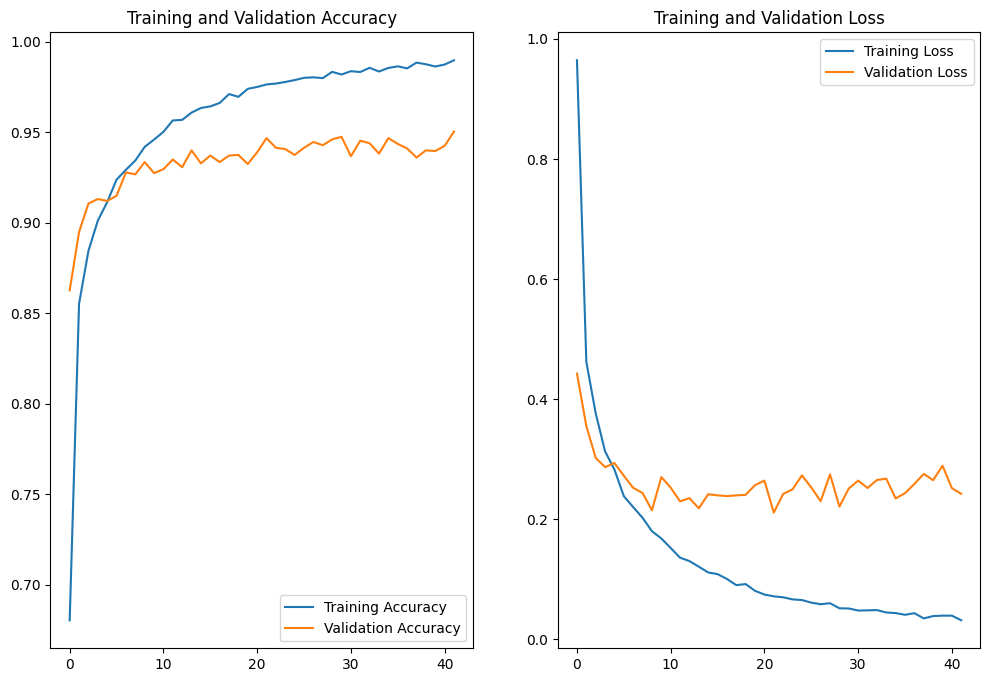

In [30]:
model = load_model(
    "model_terbaik_balanced.keras",
    custom_objects={
        "preprocess_input": tf.keras.applications.resnet50.preprocess_input
    }
)

print("Model berhasil dimuat!")

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(42)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Memuat model dari model_terbaik_balanced.keras...
88/88 ━━━━━━━━━━━━━━━━━━━━ 12s 114ms/step


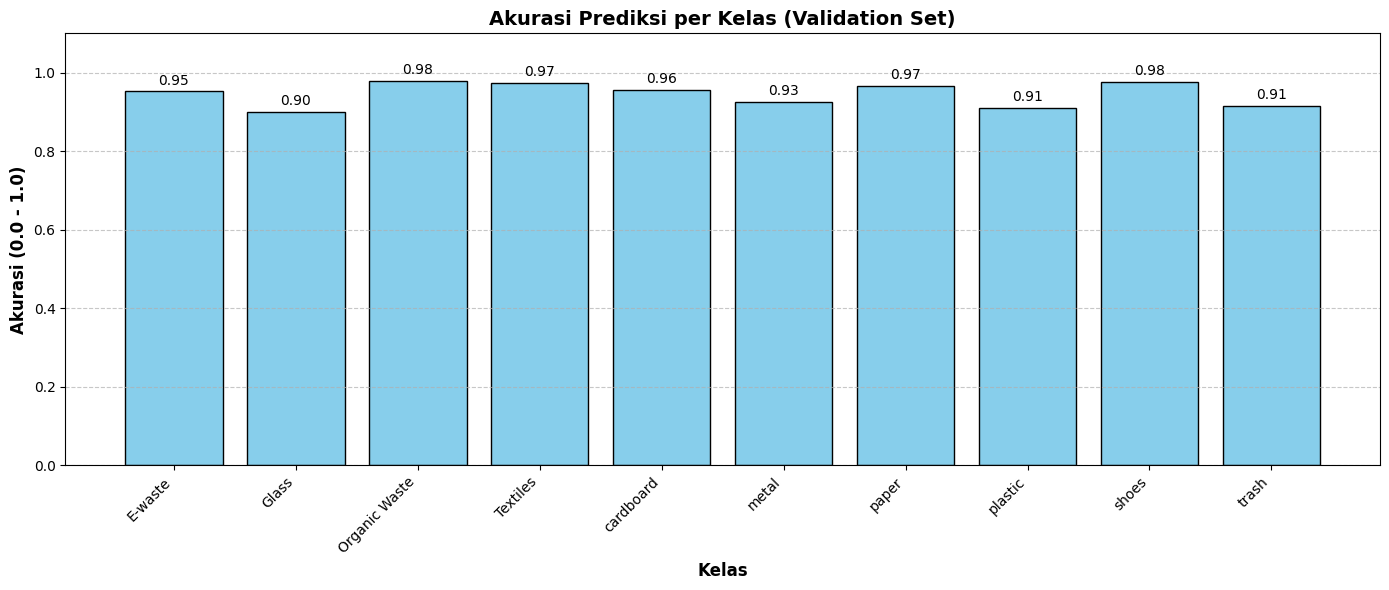


 Evaluasi
               precision    recall  f1-score   support

      E-waste       0.95      0.95      0.95       291
        Glass       0.93      0.90      0.92       300
Organic Waste       0.99      0.98      0.98       287
     Textiles       0.97      0.97      0.97       300
    cardboard       0.97      0.96      0.96       300
        metal       0.89      0.93      0.91       280
        paper       0.95      0.97      0.96       273
      plastic       0.92      0.91      0.92       300
        shoes       0.95      0.98      0.96       300
        trash       0.94      0.91      0.93       164

     accuracy                           0.95      2795
    macro avg       0.95      0.95      0.95      2795
 weighted avg       0.95      0.95      0.95      2795



In [34]:
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import load_model


print(f"Memuat model dari {model_path}...")
model = load_model(
    "model_terbaik_balanced.keras",
    custom_objects={
        "preprocess_input": tf.keras.applications.resnet50.preprocess_input
    }
)
val_generator.reset()


y_pred_prob = model.predict(val_generator, verbose=1)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = val_generator.classes
class_names = list(val_generator.class_indices.keys())


cm = confusion_matrix(y_true, y_pred)
class_accuracy = cm.diagonal() / cm.sum(axis=1)

plt.figure(figsize=(14, 6))
bars = plt.bar(class_names, class_accuracy, color='skyblue', edgecolor='black')

plt.xlabel('Kelas', fontsize=12, fontweight='bold')
plt.ylabel('Akurasi (0.0 - 1.0)', fontsize=12, fontweight='bold')
plt.title('Akurasi Prediksi per Kelas (Validation Set)', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right') 
plt.ylim(0, 1.1) 
plt.grid(axis='y', linestyle='--', alpha=0.7)


for bar, acc in zip(bars, class_accuracy):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height + 0.01, 
             f'{acc:.2f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


print("\n Evaluasi")
print(classification_report(y_true, y_pred, target_names=class_names))

Memuat model dari model_terbaik_balanced.keras...
88/88 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step


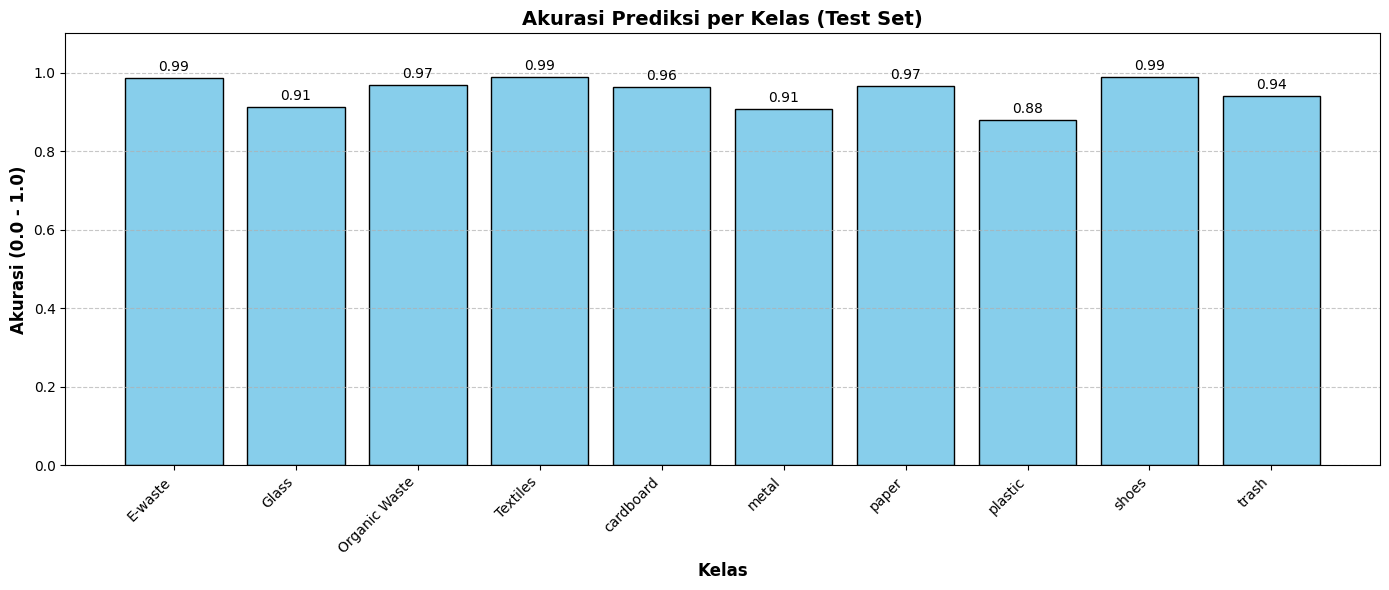


 Evaluasi
               precision    recall  f1-score   support

      E-waste       0.95      0.99      0.97       293
        Glass       0.92      0.91      0.92       300
Organic Waste       0.99      0.97      0.98       286
     Textiles       0.97      0.99      0.98       300
    cardboard       0.96      0.96      0.96       300
        metal       0.90      0.91      0.90       282
        paper       0.96      0.97      0.97       273
      plastic       0.94      0.88      0.91       300
        shoes       0.97      0.99      0.98       300
        trash       0.95      0.94      0.95       165

     accuracy                           0.95      2799
    macro avg       0.95      0.95      0.95      2799
 weighted avg       0.95      0.95      0.95      2799



In [38]:
print(f"Memuat model dari {model_path}...")
model = load_model(
    "model_terbaik_balanced.keras",
    custom_objects={
        "preprocess_input": tf.keras.applications.resnet50.preprocess_input
    }
)
test_generator.reset()


y_pred_prob = model.predict(test_generator, verbose=1)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())


cm = confusion_matrix(y_true, y_pred)
class_accuracy = cm.diagonal() / cm.sum(axis=1)

plt.figure(figsize=(14, 6))
bars = plt.bar(class_names, class_accuracy, color='skyblue', edgecolor='black')

plt.xlabel('Kelas', fontsize=12, fontweight='bold')
plt.ylabel('Akurasi (0.0 - 1.0)', fontsize=12, fontweight='bold')
plt.title('Akurasi Prediksi per Kelas (Test Set)', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right') 
plt.ylim(0, 1.1) 
plt.grid(axis='y', linestyle='--', alpha=0.7)


for bar, acc in zip(bars, class_accuracy):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height + 0.01, 
             f'{acc:.2f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


print("\n Evaluasi")
print(classification_report(y_true, y_pred, target_names=class_names))

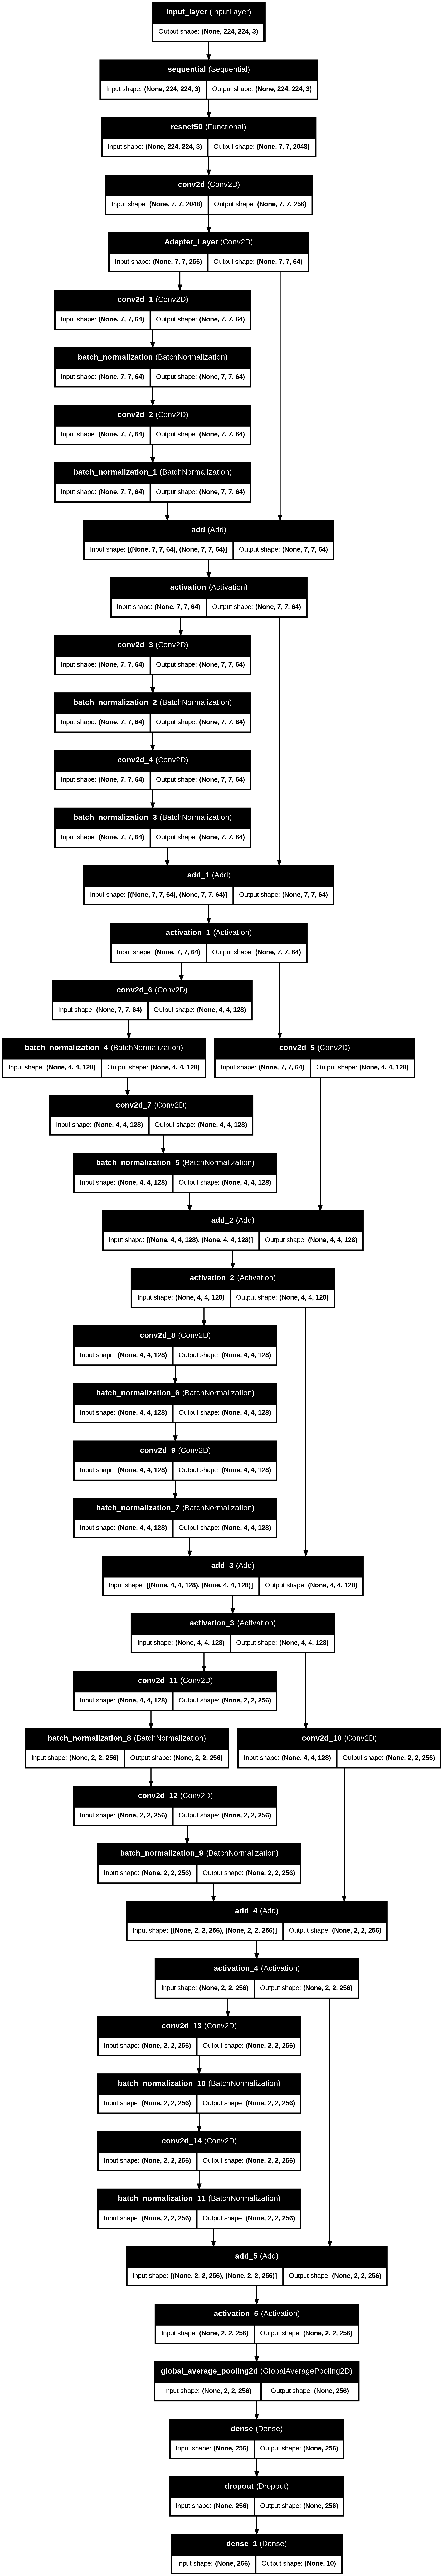

In [37]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
